# Введение

Вас перевели в отдел инновационной разработки рекомендательных систем. Ваш работадель хочет увеличить средний чек продаж. После короткого изучения статей вы поняли, что ключом к успеху будет качественные рекомендации на сайте. Чем лучше вы сможете рекомендовать товар пользователю, тем чаще он будет добавлять товары в корзину. Простая логика, если пользователю нравится товар, он его добавляет в корзину -> средний чек растёт. Мы нашли золото!

Датасет

У вас будет история оценок пользователя вместе с его обзором. Вы можете использовать текст рецензии в качестве дополнительной информации. Все оценки пользователей нормированы для бинарной классификации, если человек поставил оценку продукту больше 3 (не включительно), то мы считаем, что продукт ему понравился, если меньше 4, то продукт не понравился.

Метрики

В качестве метрики для оценки ваших рекомендаций используется RocAuc.

Условия соревнования

Данное соревнование является бессрочным и доступно для всех потоков. Срок выполнения соревнования устанавливаеться индивидуально в каждом потоке. Тестовая выборка представлена в ЛидерБорде целиком, поэтому лучшие и победные решения буду проверяться на их "адекватность" (чтоб не было подгонки под тестовую выборку). В данном соревновании вам ненужны дополнительные внешние данные. Запрещается их использовать Разрешено использовать любые ML алгоритмы и библиотеки.

-test.csv - набор данных, для которого вы должны сделать предсказания. У каждого наобора userid, itemid есть свой id, для которого вы должны сделать предсказание.

overall - рейтинг, который поставил пользователь
verified - был ли отзыв верифицирован
reviewTime - когда был отзыв написан
reviewerName - имя пользователя
reviewText - текст отзыва
summary - сжатый отзыв
vote - количество голосований за отзыв
style - метаданные
image - изображение продукта
userid - id пользователя
itemid - id товара
id - id для предсказания

# Импорт библиотек

In [1]:
import numpy as np 
import pandas as pd 
import scipy.sparse as sparse
from lightfm import LightFM
import sklearn
from sklearn.model_selection import train_test_split
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import f1_score
import itertools

E:\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Объявление вспомогательных функций

In [2]:
# Подсчет "хороших" слов в отзыве
def good_words_counter(text):
    counter = 0
    good_words_list = [
        "best",
        "good",
        "great",
        "love",
        "delicious",
        "nice",
        "favorite",
        "tasty",
        "perfect",
        "excellent",
        "wonderful",
        "enjoy",
        "yummy",
        "happy",
        "loves",
        "loved",
        "amazing",
        "awesome",
        "yum",
        "enjoyed",
        "fantastic",
        "perfectly",
        "wow",
        "lovely",
        "beautiful",
        "terrific",
        "enjoyable",
        'every day',
        'subscribe',
        'save',
        'five',
        'easy',
        'divine',
        'exquisite',
        'delicate',
        'wide',
        ]
    text = re.sub(r"[.,!?]", '', text.lower())
    for word in text.split(' '):
        if word in good_words_list:
            counter +=1
    return counter

In [3]:
# Подсчет "плохих" слов в отзыве
def bad_words_counter(text):
    counter = 0
    bad_words_list = [
        "awful",
        "bad",
        "disappointed",
        "unfortunate",
        "waste",
        "weird",
        "difficult",
        "terrible",
        "horrible",
        "complaint",
        "gross",
        "worst",
        "strange",
        "fake",
        "disappointing",
        "complaints",
        "poor",
        "sucks",
        'gmo',
        'malformed',
        'melted',
        'unwise',
        'not',
        'off',
        'weak'
        'chemical',
        'crap',
        'never',
        'crazy',
        'illegal',
        'missing',
        'itch',
        'lost',
        'puked',
        'sore',
        'rancid',
        'mangled',
        'scam',
        'yuck',
        'pain'
    ]
    text = re.sub(r"[.,!?]", '', text.lower())
    for word in text.split(' '):
        if word in bad_words_list:
            counter +=1
    return counter

In [4]:
# Функция оценки работы алгоритма определения тональности отзыва

def test_tone(column1,column2, rank, overall):
    alllist = []
    for index in train.loc[train[column1]==rank][column2].index:
        alllist.append(train.loc[index]['overall'])
    print(f'Доля отзывов с оценкой {overall} среди всех отзывов, набравших {rank} баллов: {round(alllist.count(overall)/len(alllist),3)}')
    corr_c = np.corrcoef(train.overall, train[column1])[0,1]
    print(f'Коэффициент корреляции между оценкой пользователя и {column1}: {round(corr_c,3)}')

In [5]:
# Аналог GridSearch для LightFM, на вход подается два списка для параметров NUM_COMPONENTS, NUM_EPOCHS, 
# на выходе информация о лучших результатах по roc_auc и лучшие параметры
def MyGrid(NUM_COMPONENTS, NUM_EPOCHS):   
    best_model = {}
    for i in list(itertools.product(NUM_COMPONENTS, NUM_EPOCHS)):
            model = LightFM(learning_rate=0.1, loss='logistic',
                            no_components=i[0])
            model = model.fit(ratings_coo, epochs=i[1], 
                              num_threads=NUM_THREADS)
            preds_test = model.predict(test_data.userid.values,
                              test_data.itemid.values)
            best_model[f'COMPONENTS_{i[0]}, EPOCHS_{i[1]}'] = sklearn.metrics.roc_auc_score(test_data.rating,preds_test)
    best_params = [params for params, value in best_model.items() if value == sorted(best_model.values())[-1]]
    print(f'best_params = {best_params}, best_performance = {best_model[best_params[0]]}')

# Работа с данными

In [6]:
#Читаем файлы
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

E:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
E:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
#  Поглядим, что внутри
test.head()

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4


In [8]:
train.head()

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


In [9]:
# Поглядим, что у нас в json к решению.
with open ('meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))

In [10]:
meta_list[0]

{'category': ['Grocery & Gourmet Food',
  'Dairy, Cheese & Eggs',
  'Cheese',
  'Gouda'],
 'description': ['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS',
  'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.'],
 'title': 'Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs',
 'brand': 'Ariola Imports',
 'rank': '165,181inGroceryGourmetFood(',
 'also_view': ['B0000D9MYM',
  'B0000D9MYL',
  'B00ADHIGBA',
  'B00H9OX598',
  'B001LM42GY',
  'B001LM5TDY'],
 'main_cat': 'Grocery',
 'price': '$41.91',
 'asin': '0681727810'}

In [11]:
# Создадим списки параметров товаров на основании информации из json
list_asin, list_title, list_rank, list_cat, list_brand, list_also, list_price = [], [], [],[],[],[],[]
for product in meta_list:
    try:
        list_asin.append(product['asin'])
    except:
        list_asin.append('None')
    try:
        list_title.append(product['title'])
    except:
        list_title.append('None')
    try:
        list_rank.append(product['rank'])
    except:
        list_rank.append('None')
    try:
        list_cat.append(product['main_cat'])
    except:
        list_cat.append('None')   
    try:
        list_brand.append(product['brand'])
    except:
        list_brand.append('None') 
    try:
        list_also.append(product['also_view'])
    except:
        list_also.append('None')
    try:
        list_price.append(product['price'])
    except:
        list_price.append('None')

In [12]:
# Создадим датафрей с этими фичами.
meta_df = pd.DataFrame({'asin':list_asin, 'title':list_title,'rank':list_rank,'category':list_cat,
                        'brand':list_brand,'also_view':list_also,'price':list_price})
   

In [13]:
# Оценим, сколько пропусков в новом датафрейме
for column in meta_df.columns:
    print(column, round(len(meta_df.loc[meta_df[column]=='None'])/len(meta_df),3))
# Самые пустые колонки - price и also_view

asin 0.0
title 0.0
rank 0.041
category 0.005
brand 0.04
also_view 0.579
price 0.54


In [14]:
# Оценим сколько пропусков в тренировочном датасете
train.isna().sum()

overall                0
verified               0
reviewTime             0
asin                   0
reviewerName         176
reviewText           279
summary              170
unixReviewTime         0
vote              739155
style             413489
image             850753
userid                 0
itemid                 0
rating                 0
dtype: int64

In [15]:
# Посмотрим, каике значения могут принимать параметры разных колонках
train['reviewerName'].value_counts(dropna = False)

Amazon Customer          31726
Kindle Customer           6228
Linda                      734
John                       725
David                      619
                         ...  
Mandie Kramer                1
 James &amp; Michelle        1
Chrissy Quick                1
qwertyuiop                   1
RussellF                     1
Name: reviewerName, Length: 101208, dtype: int64

In [16]:
train['vote'].value_counts(dropna = False)

NaN      739155
2.0       30887
3.0       15449
2         13616
4.0        8934
          ...  
404.0         1
414.0         1
425.0         1
507.0         1
360.0         1
Name: vote, Length: 478, dtype: int64

In [17]:
# Соотнесем значения в тестовом датафрейме и в данных из json
for item in ['title','category','brand','also_view','price']:
    mapper = dict(zip(meta_df['asin'],meta_df[item]))
    train[item] = train.asin.apply(lambda x: mapper[x])
    test[item] = test.asin.apply(lambda x: mapper[x])
train.price.loc[train.price=='None'] = None

E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Визуализация

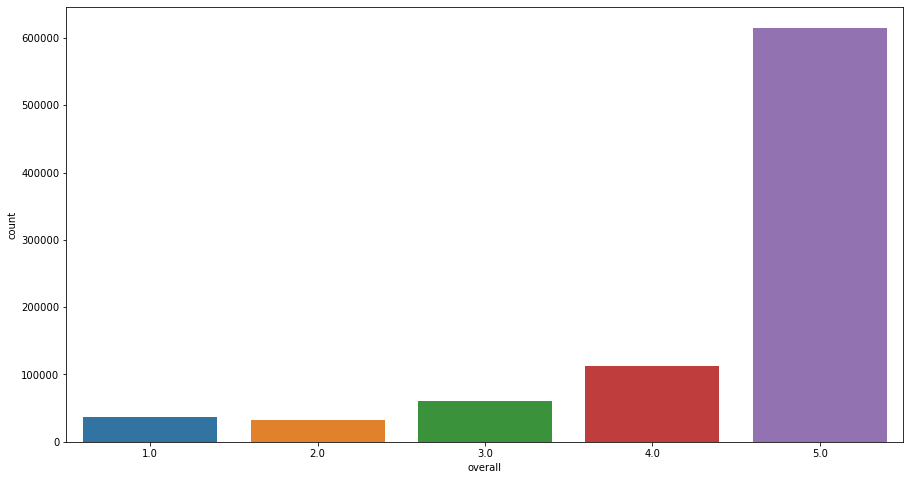

In [18]:
# Распределение оценок по их количеству. Очень много товаров имеют оценку 5.
plt.figure(figsize=(15,8))
ax = sns.countplot(train.overall)

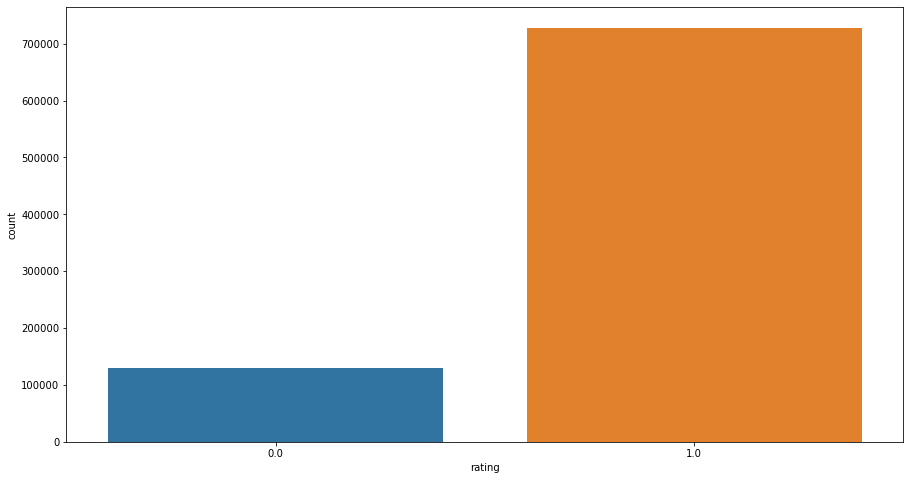

In [19]:
# Распределение по "целевой" переменной rating - как видно, классы не сбалансированы
plt.figure(figsize=(15,8))
ax = sns.countplot(train.rating)

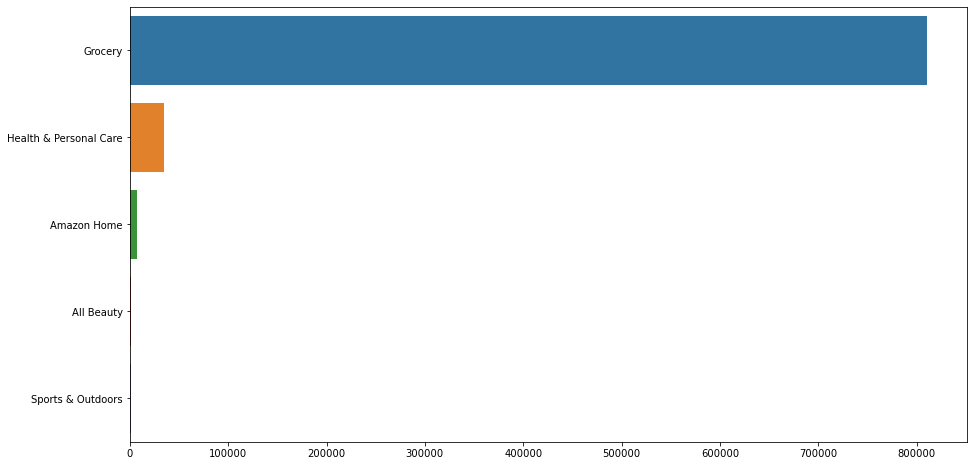

In [20]:
# Количество товаров по категориям, большй перевес в сторону продуктов.
x = train.category.value_counts().keys()[0:5]
y = train.category.value_counts().values[0:5]

plt.figure(figsize=(15,8))
ax = sns.barplot(y,x)

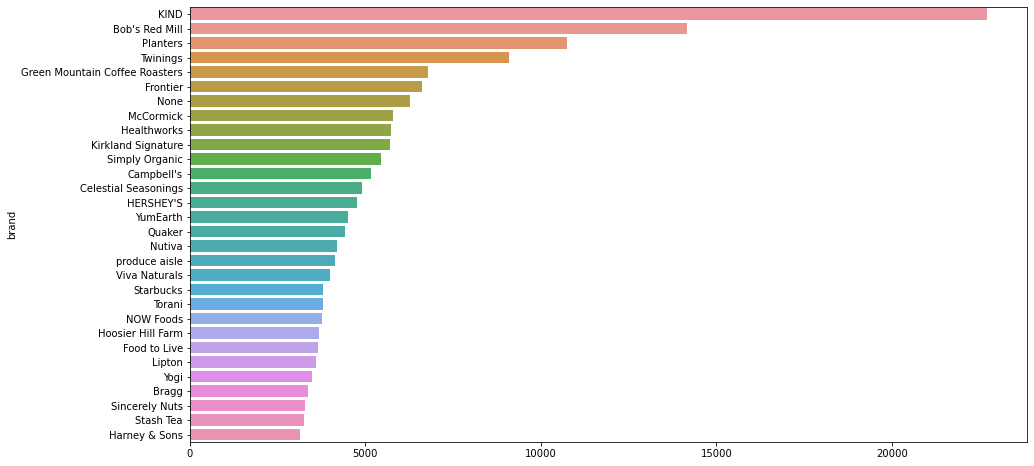

In [21]:
# Количество товаров по производителям. Что-то знакомое для меня начинается аж с 12й позиции ;)
x = train.groupby('brand')['asin'].count().sort_values(ascending = False).keys()[0:30]
y = train.groupby('brand')['asin'].count().sort_values(ascending = False).values[0:30]
plt.figure(figsize=(15,8))
ax = sns.barplot(y,x)

In [22]:
# Обработка параметра price. На данном этапе он представляет собой строку, иногда содержит диапазон цен.
# Приведем все цены к изх минимальному значению.
train.price.map({'None':None})
train['price'] = train['price'].astype('str').apply(lambda x: x.replace('$', ''))
train[train['price'].str.contains("-") == True]['price'].value_counts()
train['price'] = train['price'].apply(lambda x: re.sub("-.*", "",  x) if type(x) == str else None)
train['price'] = train['price'].apply(lambda x: float(x) if x != 'None' else None)

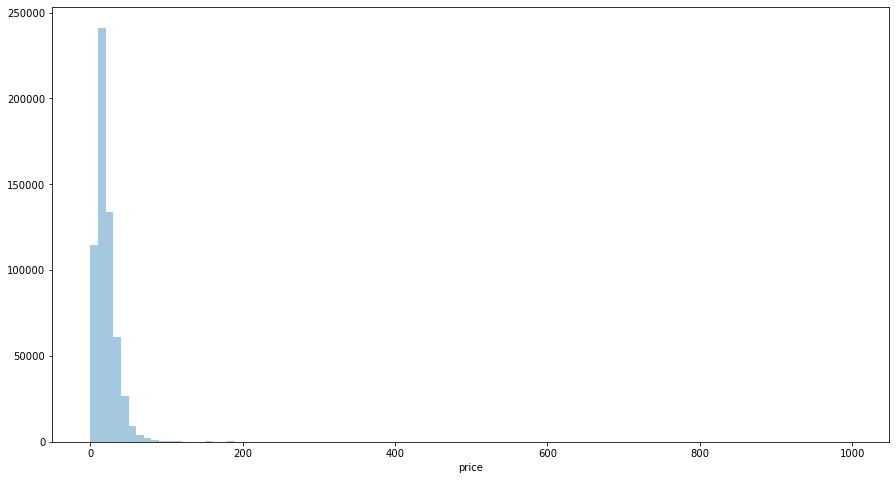

In [23]:
# Посмотрим разброс цен. Большой перевес в сторону дешешвых товаров.
plt.figure(figsize=(15,8))
ax = sns.distplot(train['price'], bins = 100, kde = False)

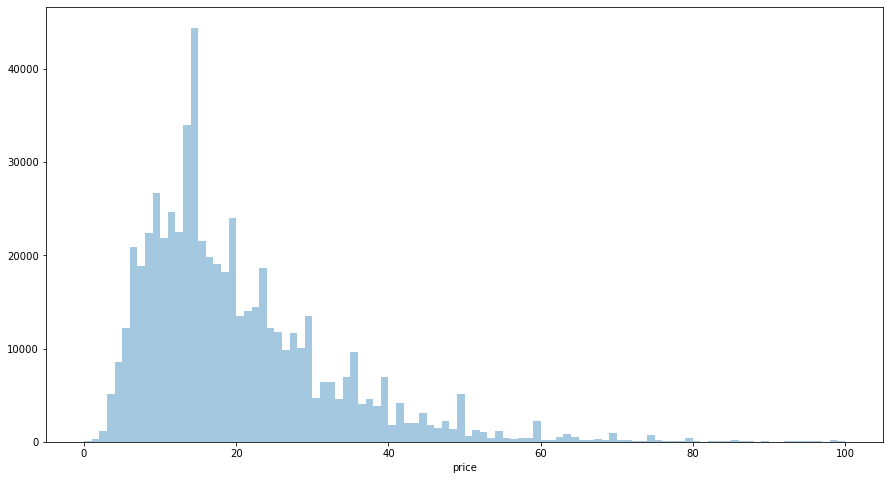

In [24]:
# Разброс цен для товаров до 100 долларов
plt.figure(figsize=(15,8))
ax = sns.distplot(train['price'].loc[train['price']< 100], bins = 100, kde = False)


In [25]:
# Оценим долю товаров больше 100 долларов
part = round(len(train['price'].loc[train['price']> 100])/len(train['price']),4)
print(f'Доля товаров дороже 100 долларов: {part*100}%')

Доля товаров дороже 100 долларов: 0.19%


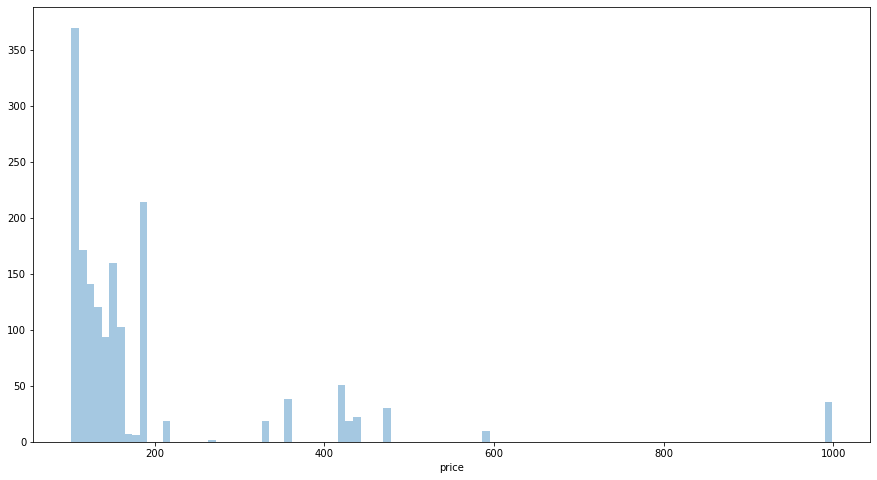

In [26]:
# Разброс цен на товары больше 100 долларов
plt.figure(figsize=(15,8))
ax = sns.distplot(train['price'].loc[train['price']> 100], bins = 100, kde = False)


In [27]:
# Будем заменять пропуски на значения средних цен по категориям.
train.groupby('category').mean()['price']

category
All Beauty                   13.368239
Amazon Home                  14.830598
Arts, Crafts & Sewing        15.749333
Baby                          8.448000
Camera & Photo                     NaN
Cell Phones & Accessories          NaN
Grocery                      20.905416
Health & Personal Care       18.820826
Home Audio & Theater               NaN
Industrial & Scientific      27.567190
Musical Instruments                NaN
None                         16.486915
Office Products              18.640600
Pet Supplies                 24.953182
Software                           NaN
Sports & Outdoors            13.837413
Tools & Home Improvement     28.233750
Toys & Games                 10.713295
Name: price, dtype: float64

In [28]:
# При более глубоком анализе выяснилось, что товары из категорий где нет средней цены, содержатся 
# в очень малом количестве и не будут влиять на общую картину. Избавляемся от них.
train.drop(train.loc[train['category']=='Camera & Photo'].index, inplace = True)
train.drop(train.loc[train['category']=='Cell Phones & Accessories'].index, inplace = True)
train.drop(train.loc[train['category']=='Home Audio & Theater'].index, inplace = True)
train.drop(train.loc[train['category']=='Musical Instruments'].index, inplace = True)
train.drop(train.loc[train['category']=='Software'].index, inplace = True)

In [29]:
# Заполняем пропуски
median_price_dict = train.groupby('category').median().to_dict()['price']
train['price'] = train['price'].fillna(train['category'].map(median_price_dict))

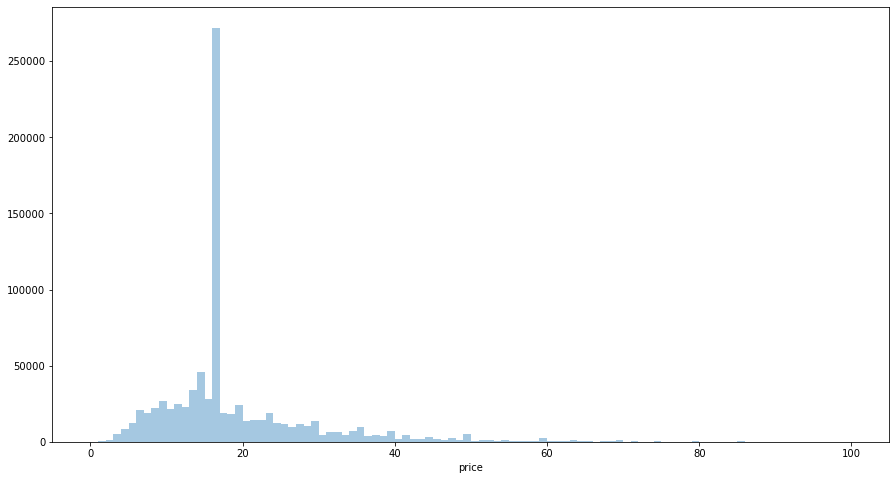

In [30]:
# Разброс цен для товаров до 100 долларов после замены
plt.figure(figsize=(15,8))
ax = sns.distplot(train['price'].loc[train['price']< 100], bins = 100, kde = False)


In [31]:
# Визуализируем признак image. Тоже очень несбалансированный признак.
sns.countplot(train.image)

Error in callback <function flush_figures at 0x00000276113BF040> (for post_execute):


KeyboardInterrupt: 

# Feature engineering

In [32]:
# Заполним колонку reviewerName н самое частое значение.
train['reviewerName'].fillna(train['reviewerName'].mode()[0], inplace = True)

In [33]:
# Самое распространенное саммари
train['summary'].mode()

0    Five Stars
dtype: object

In [34]:
# Самая распространенная оценка среди всех товаров без саммари
train.loc[train['summary'] != train['summary']]['overall'].value_counts()

5.0    145
4.0     12
1.0      9
2.0      3
3.0      1
Name: overall, dtype: int64

In [35]:
# Не сильно погрешим против истины, заменив nan на five stars.
train['summary'].fillna(train['summary'].mode()[0], inplace = True)

In [36]:
# Предобработка признака vote, заменим пропуски на 0
train['vote'] = train['vote'].astype('str').apply(lambda x: x.replace(',', '.'))
train['vote'] = train['vote'].apply(lambda x: float (x) if x == x else x)
train['vote'].value_counts()
train['vote'].fillna(0, inplace = True)

In [37]:
# После просмотра содержимого колонка style оказалась неинформативной
train.drop(columns = ['style'], inplace = True)

In [38]:
# Сделаем признак Image категориальным, 1 если картинка есть и 0, если нет
train['image'] = train['image'].apply(lambda x: 1 if x == x else 0)

In [39]:
# Закодируем переменную verified
verified_dict = {True: 1,False: 0}
train['verified'] = train['verified'].map(verified_dict)

In [40]:
# Закодируем переменную reviewerName в соответствии с наполнением: 1 если это Amazon/Kindle Customer, 0 если остальное.
train['reviewerName'] = train['reviewerName'].apply(lambda x: 1 if x == 'Amazon Customer' or x=='Kindle Customer' else 0)

In [41]:
train['reviewText'].fillna('None', inplace = True)

In [42]:
# Оценим тональность отзывов и саммари на продукты
train['good_review_score'] = train['reviewText'].apply(lambda x: good_words_counter(x))
train['good_summary_score'] = train['summary'].apply(lambda x: good_words_counter(x))
train['bad_review_score'] = train['reviewText'].apply(lambda x: bad_words_counter(x))
train['bad_summary_score'] = train['summary'].apply(lambda x: bad_words_counter(x))

In [43]:
# Далее небольшой тест на корректность оценки между тем, как оценивал отзыв алгоритм и оценкой продукта пользователем
# Для плохих отзывов, чем больше доля отзывов с оценкой 1, тем лучше.
test_tone('bad_review_score','reviewText',5,1)

Доля отзывов с оценкой 1 среди всех отзывов, набравших 5 баллов: 0.18
Коэффициент корреляции между оценкой пользователя и bad_review_score: -0.3


In [44]:
# Для хороших отзывов, чем больше доля отзывов с оценкой 5, тем лучше
test_tone('good_review_score','reviewText',5,5)
# Алгоритм хорошо определяет хорошие отзывы и часто ошибается в плохих.

Доля отзывов с оценкой 5 среди всех отзывов, набравших 5 баллов: 0.793
Коэффициент корреляции между оценкой пользователя и good_review_score: 0.2


In [45]:
# Аналогично с саммари
test_tone('good_summary_score','summary', 3, 5)

Доля отзывов с оценкой 5 среди всех отзывов, набравших 3 баллов: 0.904
Коэффициент корреляции между оценкой пользователя и good_summary_score: 0.409


In [46]:
test_tone('bad_summary_score','summary', 3, 1)
# Алгоритм хорошо работает, определяя хорошие отзывы и часто ошибается при определении плохих, но в даьлнейшем я покажу, 
# что эти фичи все равно важны.

Доля отзывов с оценкой 1 среди всех отзывов, набравших 3 баллов: 0.119
Коэффициент корреляции между оценкой пользователя и bad_summary_score: -0.346


In [47]:
# Удалим лишние признаки
train.drop(columns = ['reviewText','summary','reviewTime','unixReviewTime','title'], inplace = True)

In [48]:
# Перекодируем also_view следующим образом - количество сопутствующих товаров
train['also_view'] = train['also_view'].apply(lambda x: len(x) if x!='None' else 0)

In [49]:
# Признак asin не нужен, так как есть itemid
train.drop(columns = ['asin'], inplace = True)

In [50]:
# Выделяю категориальные перменные и кодирую их
cat_f = []
for item in train.columns:
    if type(train[item][0])== str:
        cat_f.append(item)
for col in cat_f:
    train[col] = train[col].astype('category').cat.codes

# Machine learning

In [51]:
# Подготовим данные для модели, предсказывающей, купит ли пользователь данный товар или нет (1 - купит, 0 - нет)
X = train.drop(columns = ['rating', "overall"])
y = train['rating']

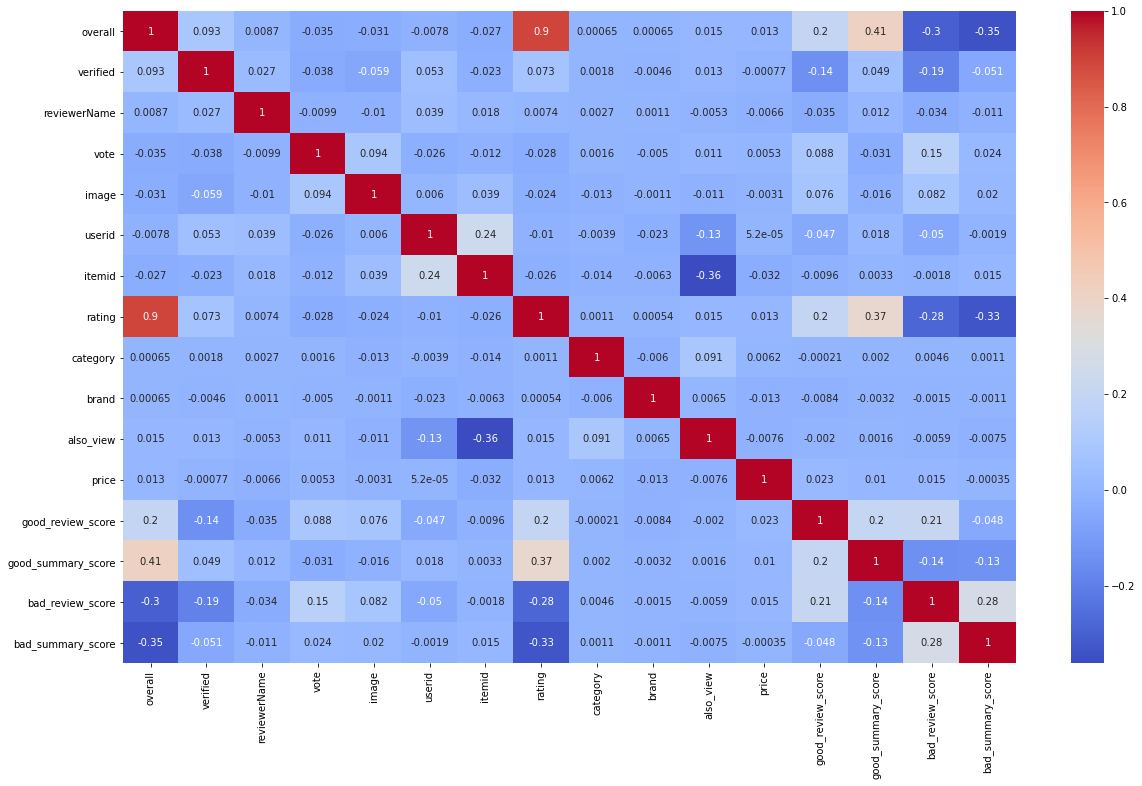

In [52]:
#  Построим матрицу корреляций для существующих фич. Как видно, фичи, 
# связанные с отзывами имеют бОльшую корреляцию с целевой переменной, чем остальные.
correlation = train.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [53]:
# Разбиваем датасет на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [54]:
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_f)

In [55]:
eval_dataset = Pool(data=X_test,
                    label=y_test,
                    cat_features=cat_f)

In [56]:
# Для предсказания будем использовать CatBoostClassifier
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.2,
                           depth=10)

In [57]:
model.fit(train_dataset, plot = True, verbose = 25)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5719826	total: 267ms	remaining: 26.4s
25:	learn: 0.2570921	total: 2.64s	remaining: 7.52s
50:	learn: 0.2545054	total: 4.91s	remaining: 4.72s
75:	learn: 0.2529096	total: 7.25s	remaining: 2.29s
99:	learn: 0.2516953	total: 9.52s	remaining: 0us


In [58]:
# Получим предсказанные классы
preds_class = model.predict(eval_dataset)


In [59]:
# Оценка точности модели по метрике f1. Вроде неплохо.
f1_score(y_test, preds_class)

0.9376049675144362

In [60]:
# Посмотрим важность признаков. Все признаки, связанные с анализом текста оказались в топе по важности.
model.get_feature_importance(prettified = True)

,Feature Id,Importances
0,good_summary_score,36.656605
1,good_review_score,15.669056
2,bad_review_score,14.140236
3,bad_summary_score,11.015598
4,brand,7.089541
5,vote,3.250658
6,userid,2.425937
7,verified,2.366135
8,price,2.235195
9,itemid,2.218022


In [61]:
# Этот трюк позволяет получить больший балл на каггле 
# train = pd.concat([train, train])

# Рекомендательная система

In [62]:
# Для построения рекомендательной системы будем использовать библиотеку LightFM.
# Поделим данные
train_data, test_data = train_test_split(train,random_state=42, shuffle=True)

Чтобы работать с моделями в библиотеке LightFm, нам нужно создать разреженные матрицы. Мы будем хранить данные в формате COO (координатный формат представления данных). Вместо хранения всех значений, которые включают нулевые значения, мы будем хранить только ненулевые значения. В COO данные представлены в виде (строка, столбец, значение).

Формируем разреженную матрицу

ratings_coo: размером train_data.userid(row) * train_data.itemid(col), с соответствующим значением рейтинга товара train_data.rating в полях

In [63]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [64]:
# В качестве первого приближения будем использовать параметры из baseline решения.
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 15 #число параметров вектора 
NUM_EPOCHS = 10 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [65]:
preds_test = model.predict(test_data.userid.values,
                      test_data.itemid.values)

In [66]:
metric_wo_grid = sklearn.metrics.roc_auc_score(test_data.rating,preds_test)
print(metric_wo_grid)

0.7415233392414311


In [67]:
# Воспольземся подобием gridsearch для того, чтобы подобрать оптимальные параметры 
# (праметры были подобраны заранее, тут только ближайшие значения)
NUM_COMPONENTS = [50,60,70]
NUM_EPOCHS = [10,20,30]

In [68]:
MyGrid(NUM_COMPONENTS, NUM_EPOCHS)

best_params = ['COMPONENTS_60, EPOCHS_20'], best_performance = 0.7497589977343169


In [80]:
# Применим параметры после поиска
model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=60)
model = model.fit(ratings_coo, epochs=20, 
                  num_threads=4)

In [81]:
preds_test = model.predict(test_data.userid.values,
                      test_data.itemid.values)

In [82]:
metric_grid = sklearn.metrics.roc_auc_score(test_data.rating,preds_test)
print(metric_grid)
print(f'Улучшение составило:{round(metric_grid - metric_wo_grid,5)}%')

0.7442678800856151
Улучшение составило:0.00274%


# Проверка работоспособности рекомендаций

In [84]:
import nmslib
 
item_biases, item_embeddings = model.get_item_representations()
#Создаём наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Начинаем добавлять наши товары в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

In [90]:
#Вспомогательная функция для поиска 5 ближайших товаров по графу
def nearest_item_nms(itemid, index, n=5):
    nn = index.knnQuery(item_embeddings[itemid], k=n)
    return nn


In [91]:
# Рекомендации есть
nbm = nearest_item_nms(37138,nms_idx)[0]
nbm

array([37138, 22636, 37701, 40503, 28959])

# Submission

In [ ]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

In [ ]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission['rating']= normalized_preds

In [ ]:
submission.to_csv('baseline_sub.csv', index = False)